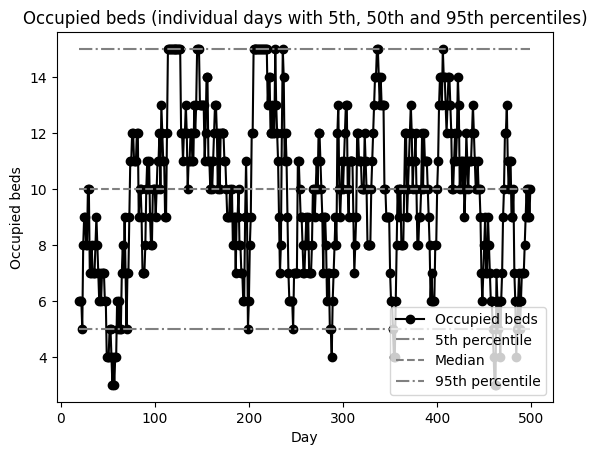

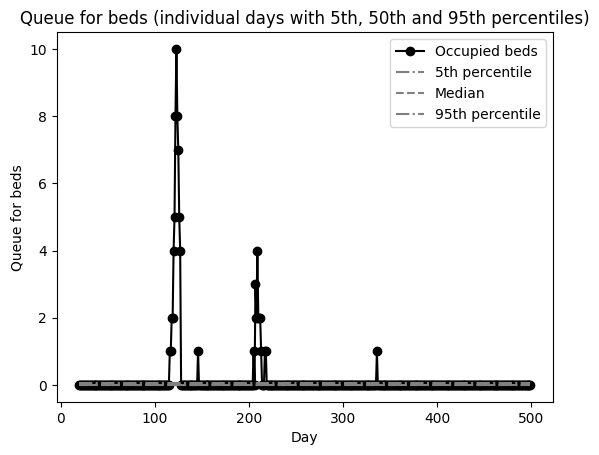

In [1]:
"""
This model requires simpy to run (pip install simpy). All other modules 
should are present in an Anaconda installation of Python 3. The model was
written in Python 3.6.

This model simulates the random arrival of patients at a hospital. Patients
stay for a random time (given an average length of stay). Both inter-arrival
time and length of stay are sampled from an inverse exponential distribution.
Average inter-arrival time and length of stay may be changed by changing their
values in class g (global variables). At intervals the number of beds occupied
are counted in an audit, and a chart of bed occupancy is plotted at the end of
the run.

There are restricted beds in the hospital. As part of the audit, the number of
people waiting for a bed are counted.

There are five classes:

g (global variables)
--------------------

This class stores global variables. No individual object instance is used;
global variables are stored as class variables.

Hospital
--------
Hospital class (one instance created):
    1) Dictionary of patients present
    2) List of audit times
    3) List of beds occupied at each audit time
    4) Current total beds occupied
    5) Admissions to data

The Hospital class contains methods for audit of beds occupied, summarising
audit (at end of run), and plotting bed occupancy over time (at end of run).

Model
-----
The model class contains the model environment. The modelling environment is
set up, and patient arrival and audit processes initiated. Patient arrival
triggers a spell for that patient in hospital. Arrivals and audit continue
fort he duration of the model run. The audit is then summarised and bed
occupancy, and number of people waiting for beds (with 5th, 50th and 95th
percentiles) plotted.

Patient
-------
The patient class is the template for all patients generated (each new patient
arrival creates a new patient object). The patient object contains patient id
and length of stay.

Resoucres
---------
This class holds the beds resource (it could also hold other resources, such as
doctors)

Main
----
Code entry point after: if __name__ == '__main__'
Creates model object, and runs model

"""

# Import required modules

import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt


class g:
    """g holds Global variables. No individual instance is required"""

    inter_arrival_time = 1  # Average time (days) between arrivals
    los = 10  # Average length of stay in hospital (days)
    sim_duration = 500  # Duration of simulation (days)
    audit_interval = 1  # Interval between audits (days)
    beds = 15  # bed capacity of hospital


class Hospital:
    """
    Hospital class holds:
    1) Dictionary of patients present
    2) List of audit times
    3) List of beds occupied at each audit time
    4) Current total beds occupied
    5) Admissions to data

    Methods:

    __init__: Set up hospital instance

    audit: records number of beds occupied

    build_audit_report: builds audit report at end of run (calculate 5th, 50th
    and 95th percentile bed occupancy.

    chart: plot beds occupied over time (at end of run)
    """

    def __init__(self):
        """
        Constructor method for hospital class"
        Initialise object with attributes.
        """

        self.patients = {}  # Dictionary of patients present
        self.patients_in_queue = {}
        self.patients_in_beds = {}
        self.audit_time = []  # List of audit times
        self.audit_beds = []  # List of beds occupied at each audit time
        self.audit_queue = []
        self.bed_count = 0  # Current total beds occupied
        self.queue_count = 0
        self.admissions = 0  # Admissions to data
        return

    def audit(self, time):
        """
        Audit method. When called appends current simulation time to audit_time
        list, and appends current bed count to audit_beds.
        """

        self.audit_time.append(time)
        self.audit_beds.append(self.bed_count)
        self.audit_queue.append(self.queue_count)
        return

    def build_audit_report(self):
        """
        This method is called at end of run. It creates a pandas DataFrame,
        transfers audit times and bed counts to the DataFrame, and 
        calculates/stores 5th, 50th and 95th percentiles.
        """
        self.audit_report = pd.DataFrame()

        self.audit_report['Time'] = self.audit_time

        self.audit_report['Occupied_beds'] = self.audit_beds

        self.audit_report['Median_beds'] = \
            self.audit_report['Occupied_beds'].quantile(0.5)

        self.audit_report['Beds_5_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.05)

        self.audit_report['Beds_95_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.95)

        self.audit_report['Queue'] = self.audit_queue

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Queue_5_percent'] = \
            self.audit_report['Queue'].quantile(0.05)

        self.audit_report['Queue_95_percent'] = \
            self.audit_report['Queue'].quantile(0.95)

        return

    def chart(self):
        """
        This method is called at end of run. It plots beds occupancy over the
        model run, with 5%, 50% and 95% percentiles.
        """

        # Plot occupied beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Occupied beds')
        plt.title(
            'Occupied beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()

        # Plot queue for beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Queue for beds')
        plt.title('Queue for beds (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()

        return


class Model:
    """
    The main model class.

    The model class contains the model environment. The modelling environment
    is set up, and patient arrival and audit processes initiated. Patient
    arrival triggers a spell for that patient in hospital. Arrivals and audit
    continue for the duration of the model run. The audit is then 
    summarised and bed occupancy (with 5th, 50th and 95th percentiles) plotted.

    Methods are:

    __init__: Set up model instance

    audit_beds: call for bed audit at regular intervals (after initial delay 
    for model warm-up)

    new_admission: trigger new admissions to hospital at regular intervals.
    Call for patient generation with patient id and length of stay, then call
    for patient spell in hospital.

    run: Controls the main model run. Initialises model and patient arrival and
    audit processes. Instigates the run. At end of run calls for an audit
    summary and bed occupancy plot.

    spell_gen: stores patient in hospital patient list and bed queue 
    dictionaries, waits for bed resource to become available, then removes 
    patient from bed queue dictionary and adds patient to hospital bed 
    dictionary and increments beds occupied. Waits for the patient length of
    stay in the hospital and then decrements beds occupied and removes patient
    from hospital patient dictionary and beds occupied dictionary.
    """

    def __init__(self):
        """
        Constructor class for new model.
        """
        self.env = simpy.Environment()

        return

    def audit_beds(self, delay):
        """
        Bed audit process. Begins by applying delay, then calls for audit at
        intervals set in g.audit_interval

        :param delay: delay (days) at start of model run for model warm-up.
        """

        # Delay first audit
        yield self.env.timeout(delay)

        # Continually generate audit requests until end of model run
        while True:
            # Call audit (pass simulation time to hospital.audit)
            self.hospital.audit(self.env.now)
            # Delay until next call
            yield self.env.timeout(g.audit_interval)

        return

    def new_admission(self, interarrival_time, los):
        """
        New admissions to hospital.

        :param interarrival_time: average time (days) between arrivals
        :param los: average length of stay (days)
        """
        while True:
            # Increment hospital admissions count
            self.hospital.admissions += 1

            # Generate new patient object (from Patient class). Give patient id
            # and set length of stay from inverse exponential distribution).
            p = Patient(patient_id=self.hospital.admissions,
                        los=random.expovariate(1 / los))

            # Add patient to hospital patient dictionary
            self.hospital.patients[p.id] = p

            # Generate a patient spell in hospital (by calling spell method).
            # This triggers a patient admission and allows the next arrival to
            # be set before the paitent spell is finished
            self.spell = self.spell_gen(p)
            self.env.process(self.spell)

            # Set and call delay before looping back to new patient admission
            next_admission = random.expovariate(1 / interarrival_time)
            yield self.env.timeout(next_admission)

        return

    def run(self):
        """
        Controls the main model run. Initialises model and patient arrival and
        audit processes. Instigates the run. At end of run calls for an audit
        summary and bed occupancy plot
        """

        # Set up hospital (calling Hospital class)
        self.hospital = Hospital()

        # Set up resources (beds)
        self.resources = Resources(self.env, g.beds)

        # Set up starting processes: new admissions and bed  audit (with delay)
        self.env.process(self.new_admission(g.inter_arrival_time, g.los))
        self.env.process(self.audit_beds(delay=20))

        # Start model run
        self.env.run(until=g.sim_duration)

        # At end of run call for bed audit summary and bed occupancy plot
        self.hospital.build_audit_report()
        self.hospital.chart()

        return

    def spell_gen(self, p):
        """
        Patient hospital stay generator. Increment bed count, wait for patient
        length of stay to complete, then decrement bed count and remove patient
        from hospital patient dictionary

        :param p: patient object (contains length of stay for patient)
        """
        # The following 'with' defines the required resources and automatically
        # releases resources when no longer required

        with self.resources.beds.request() as req:
            # Increment queue count
            self.hospital.queue_count += 1

            # Add patient to dictionary of queuing patients. This is not used
            # further in this model.
            self.hospital.patients_in_queue[p.id] = p

            # Yield resource request. Sim continues after yield when resources
            # are vailable (so there is no delay if resources are immediately
            # available)
            yield req

            # Resource now available. Remove from queue count and dictionary of
            # queued objects
            self.hospital.queue_count -= 1
            del self.hospital.patients_in_queue[p.id]

            # Add to count of patients in beds and to dictionary of patients in
            # beds
            self.hospital.patients_in_beds[p.id] = p
            self.hospital.bed_count += 1

            # Trigger length of stay delay
            yield self.env.timeout(p.los)

            # Length of stay complete. Remove patient from counts and
            # dictionaries
            self.hospital.bed_count -= 1
            del self.hospital.patients_in_beds[p.id]
            del self.hospital.patients[p.id]

        return


class Patient:
    """
    Patient class. Contains patient id and length of stay (it could contain
    other info about patient, such as priority or clinical group.

    The only method is __init__ for creating a patient (with assignment of
    patient id and length of stay).
    """

    def __init__(self, patient_id, los):
        """
        Contructor for new patient.

        :param patient_id: id of patient  (set in self.new_admission)
        :param los: length of stay (days, set in self.new_admission)
        """
        self.id = patient_id
        self.los = los

        return


class Resources:
    """
    Holds beds resources
    """

    def __init__(self, env, number_of_beds):
        """        Constructor method to initialise beds resource)"""
        self.beds = simpy.Resource(env, capacity=number_of_beds)

        return


def main():
    """
    Code entry point after: if __name__ == '__main__'
    Creates model object, and runs model
    """

    model = Model()
    model.run()

    return


# Code entry point. Calls main method.
if __name__ == '__main__':
    main()